In [ ]:
import os
os.chdir('/content/drive/MyDrive/dirclip-private/core')

In [ ]:
%%capture
!pip install dm-haiku==0.0.10

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
from jax import vmap, pmap
from tqdm.auto import tqdm
import models, datasets, distributions, utils

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
n_dev = jax.device_count()
print(f'{n_dev=}')

n_dev=8


In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [ ]:
# load dataset
ds_name = 'cifar10'
x_train, y_train, n_class = datasets.load(ds_name, 'train')
x_test,  y_test,  n_class = datasets.load(ds_name, 'test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteEHJQC0/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteEHJQC0/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# load model
key = jax.random.PRNGKey(0)
net_fn = models.make_resnet20_fn(n_class)
predict_fn, params_init = models.make_nn(net_fn, key, x_train[:1])

In [ ]:
%%time

def get_model_conf(key):
    """returns confidence for one model across all scales"""

    @jax.jit
    def get_scale_conf(std, n_data=5_000):
        """returns confidence for one model at one scale"""

        # scale params by std
        params_scaled = jax.tree_map(lambda x: std*x, params)

        # get prediction for each image
        logits = predict_fn(x_train[:n_data], params_scaled) # [n_data, n_classes]

        # return average prediction confidence over images
        probs = jax.nn.softmax(logits) # [n_data, n_classes]
        conf = probs.max(-1) # [n_data]
        return conf.mean()

    # randomly sample params
    params = utils.normal_like_tree(key, params_init)

    # iterate over scale
    conf = jax.lax.map(get_scale_conf, prior_scale_geomspace) # [n_scales]
    return conf # [n_scales]

prior_conf = []
key = jax.random.PRNGKey(0)
prior_scale_geomspace = jnp.geomspace(0.02, 10, 50)
for _ in tqdm(range(200)): # sample 200*8=1600 models
    key, _ = jax.random.split(key)
    keys = jax.random.split(key, n_dev)
    prior_conf += [jax.pmap(get_model_conf)(keys)]
prior_conf = jnp.concatenate(prior_conf)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 3min 9s, sys: 7min 2s, total: 10min 11s
Wall time: 19min 57s


In [ ]:
# save sampled confidence
jnp.save('../private/prior_conf.npy', prior_conf)

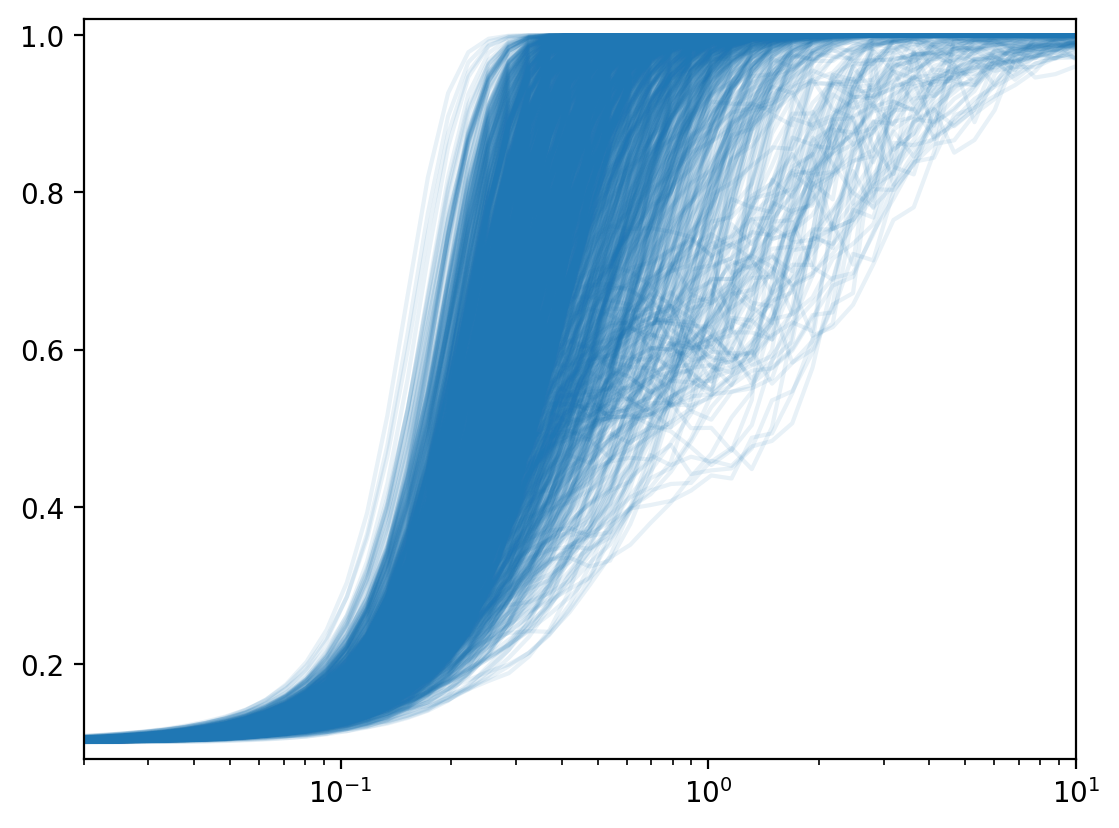

In [ ]:
# plot each sampled confidence
fig, ax = plt.subplots()
n_samples = len(prior_conf)
x = jnp.repeat(prior_scale_geomspace[None], n_samples, axis=0) # [n_samples, n_scales]
y = prior_conf # [n_samples, n_scales]
xy = jnp.stack([x, y], -1) # [n_samples, n_scales, 2]
line_collection = mpl.collections.LineCollection(xy, alpha=0.1)
ax.add_collection(line_collection)
ax.set_xlim(x.min(), x.max())
ax.set_ylim((0.08, 1.02))
ax.set_xscale('log')
plt.show()